# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # Set the model to train mode
    model.train()    
    
    # Enumerate over the dataloader to get mini batches
    # of images and ground truth labels
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # Set the optimizer's gradients to zero
        optimizer.zero_grad()
        
        # Run the network
        output = model(data)
        
        # Compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # Do backpropagation
        loss.backward()
       
        # Optimize
        optimizer.step()
       
        # Print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # Initialize network layers
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # Run network layers with sigmoid activation function
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        
        # Last layer does not need an activation function
        x = self.fc5(x)
        
        # Compute log softmax over the output
        x = F.log_softmax(x, dim=1)
        
        return x


In [5]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # Initialize network layers
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # Run network layers with ReLU activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        # Last layer does not need an activation function
        x = self.fc5(x)
        
        # Compute log softmax over the output
        x = F.log_softmax(x, dim=1)
        
        return x


In [6]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with batch normalization in the first and third layers
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # Initialize network layers
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.bn2 = nn.BatchNorm1d(60)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # Run network layers with batch normalization
        x = self.bn1(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.bn2(F.relu(self.fc3(x)))
        x = F.relu(self.fc4(x))
        
        # Last layer does not need an activation function
        x = self.fc5(x)
        
        # Compute log softmax over the output
        x = F.log_softmax(x, dim=1)
        
        return x


## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # Initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Run convolutional layers with ReLU activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # Run fully connected layers with ReLU activation function
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output


In [8]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers with batch normalization
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # Initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization for the first convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization for the first fully connected layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Run convolutional layers with batch normalization and ReLU activation function
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # Run fully connected layers with batch normalization and ReLU activation function
        x = F.relu(self.bn2(self.fc1(x)))
        x = self.fc2(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output


In [9]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers with max pooling
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # Initialize network layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Run first convolutional layer and apply ReLU activation function
        x = F.relu(self.conv1(x))
        # Apply max pooling with kernel size 2 and stride 2
        x = F.max_pool2d(x, 2, 2)
        
        # Run second convolutional layer and apply ReLU activation function
        x = F.relu(self.conv2(x))
        # Apply max pooling with kernel size 2 and stride 2
        x = F.max_pool2d(x, 2, 2)
        
        # Reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # Run fully connected layers and apply ReLU activation function
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output


Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data\MNIST\raw\train-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data\MNIST\raw\train-labels-idx1-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ../data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\MNIST\raw

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295352
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.447681
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.261030
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.054370
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.163964
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.065029
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.117160
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.042986
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.134028
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.109422

Test set: Average loss: 0.1331, Accuracy: 9603/10000 (96.03%)



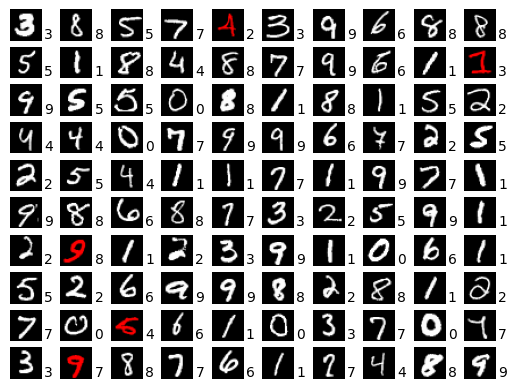

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.037939
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.026590
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.086615
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.024117
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.074560
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.117102
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.063203
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.146570
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.011465
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.008998

Test set: Average loss: 0.0960, Accuracy: 9735/10000 (97.35%)



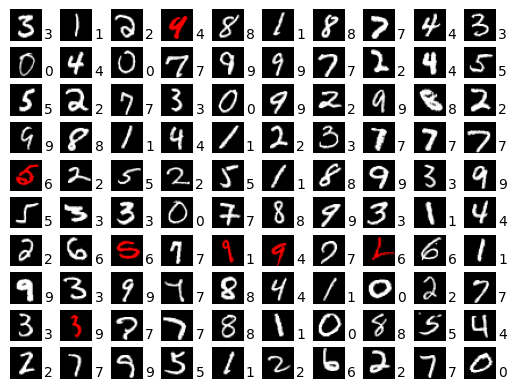

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.107437
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.057409
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.014072
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.017425
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.003765
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.096725
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.009434
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.007166
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.099741
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.012292

Test set: Average loss: 0.0761, Accuracy: 9779/10000 (97.79%)



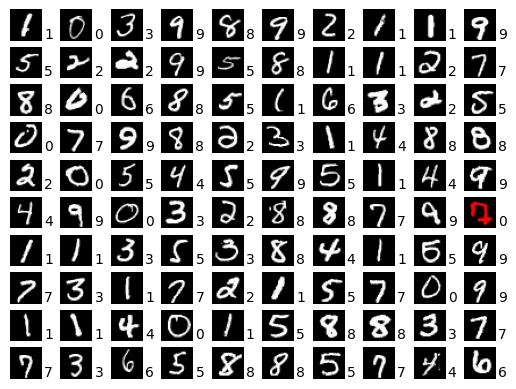

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.007461
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.019697
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.002839
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.010533
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.050271
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.032457
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.001034
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.008836
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.013093
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.003077

Test set: Average loss: 0.0749, Accuracy: 9799/10000 (97.99%)



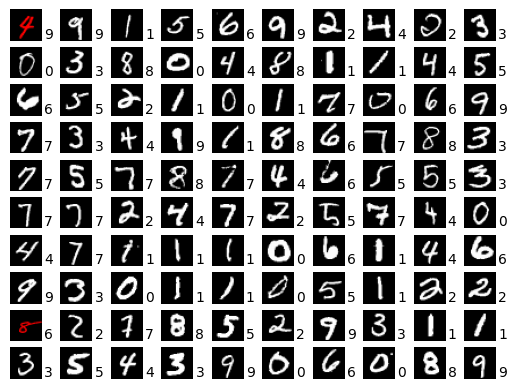

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.003418
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.002365
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.036059
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.011767
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.011365
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.008091
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.090012
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.014325
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.028932
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.014191

Test set: Average loss: 0.0791, Accuracy: 9811/10000 (98.11%)



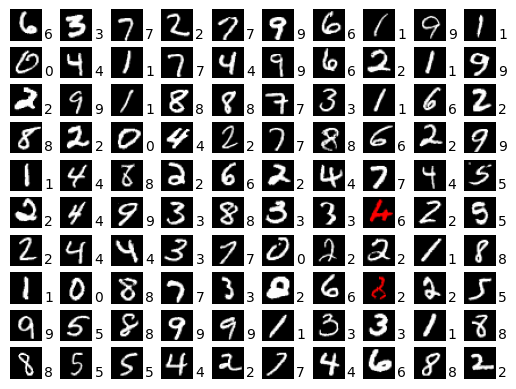

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001110
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000135
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.001833
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.009880
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000865
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000245
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000783
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.001041
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.001628
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.010079

Test set: Average loss: 0.0844, Accuracy: 9799/10000 (97.99%)



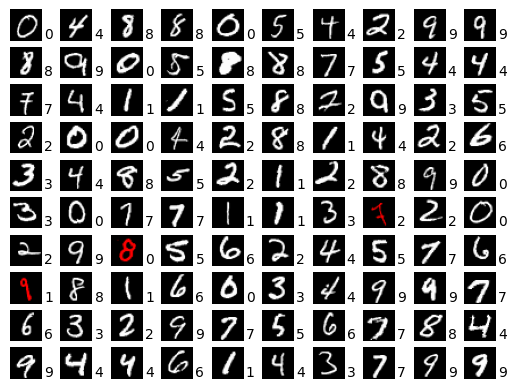

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.065950
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000633
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001189
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.002401
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.095822
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.001637
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.002299
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000533
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.029530
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.002165

Test set: Average loss: 0.0880, Accuracy: 9799/10000 (97.99%)



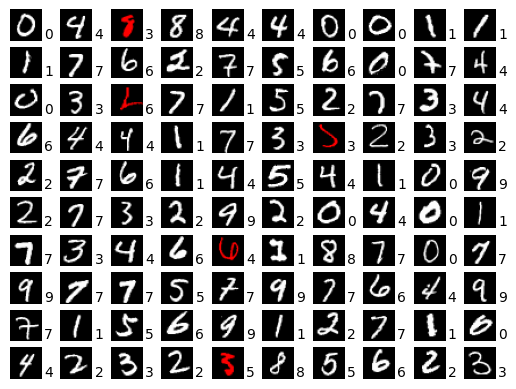

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.021996
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000317
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.004013
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.001301
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.077269
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.002584
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.004535
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.005623
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.089031
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000129

Test set: Average loss: 0.0904, Accuracy: 9804/10000 (98.04%)



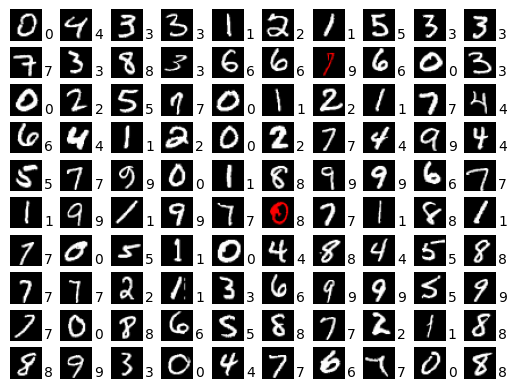

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000640
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.091933
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001082
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.001235
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000379
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001633
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.006066
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000552
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.001993
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000479

Test set: Average loss: 0.0910, Accuracy: 9807/10000 (98.07%)



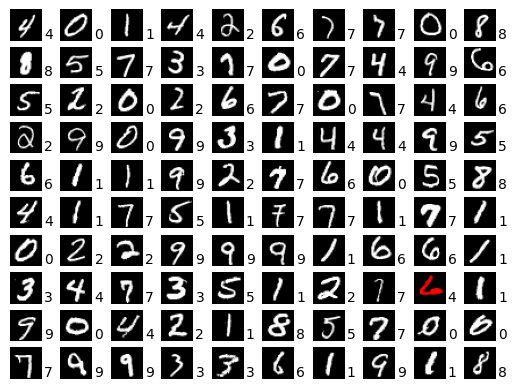

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000064
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000736
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000740
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000635
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000242
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000355
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000161
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.001033
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000229
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.001272

Test set: Average loss: 0.0922, Accuracy: 9809/10000 (98.09%)



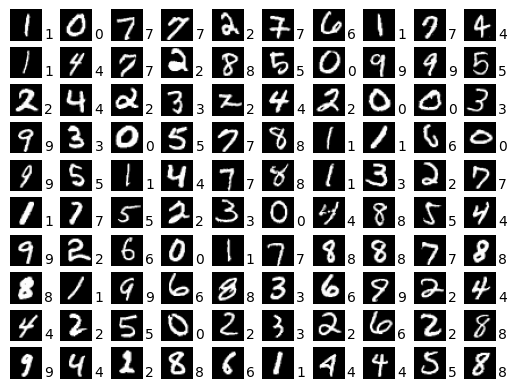

In [10]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")